In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("ds701-fa24-midterm.ipynb")

# NBA Shot Data Midterm Challenge

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
from matplotlib.dates import DateFormatter, YearLocator
import os
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder


pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

if not os.path.exists("./datasets"):
    os.makedirs("./datasets")
    os.system("unzip ./archive.zip -d ./datasets")

datasets = sorted(os.listdir("./datasets"))
print(datasets)

['.DS_Store', 'test.csv', 'train.csv']


You have the following datasets in the ./datasets directory:

* train.csv
* test.csv

For questions 1, 2, and 4, work with the `train.csv` file. Use both `train.csv` and `test.csv` for question 3 (the prediction task).

## Part 1: Exploratory analysis, visualization and outlier detection.


Please answer the following seven questions.

In [3]:
df = pd.read_csv("./datasets/train.csv")

<!-- BEGIN QUESTION -->

### Question 1-1: Unique Players

How many unique players are there? Return this value as an integer.

In [4]:
def find_n_unique_players(df):
    """
    Find and return the number of unique players as an integer.
    """
    return df['PLAYER_NAME'].nunique()

n_unique_players = find_n_unique_players(df)
print("Number of unique players", n_unique_players)

Number of unique players 2156


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1-2: Played most games

Which player has played in the most games normalized by number of games per season (82) played in the dataset? 

Return a Pandas Series with an index of ['PLAYER_NAME', 'GAME_COUNT', 'GAMES_PER_SEASON'].

In [5]:
def find_top_player_most_games(df):
    """
    Find and return the player with the most games normalized by number of games per season (82) played in the dataset.
    """
    x = df.groupby('PLAYER_NAME').agg(GAME_COUNT=('GAME_DATE', 'nunique'))
    x['GAMES_PER_SEASON'] = x['GAME_COUNT']/82
    return x.reset_index().sort_values('GAMES_PER_SEASON', ascending = False).iloc[0]
    

top_player = find_top_player_most_games(df)
print(f"Player with the most games normalized by seasons: {top_player['PLAYER_NAME']} with {top_player['GAMES_PER_SEASON']} games per season")


Player with the most games normalized by seasons: LeBron James with 18.195121951219512 games per season


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1-3: Highest Shot Players

Find the 10 players with the highest shot success rate in the 4th quarter that have taken at least 2000 shots in the 4th quarter. 

Return a Pandas dataframe of length 10 with the following columns 

- 'PLAYER_NAME' 
- 'SHOT_COUNT'  
- 'SHOTS_MADE' 
- 'SHOT_SUCCESS_RATE'

In [6]:
def find_top_10_players_q4(df):
    """
    Find and return the 10 players with the highest shot success rate in the 4th quarter that have taken at least 2000 shots in the 4th quarter.
    """
    df['QUARTER'] = df['QUARTER'].apply(lambda x: round(x))
    y = df[df['QUARTER'] == 4].groupby('PLAYER_NAME').agg(SHOT_COUNT=('SHOT_MADE', 'count'),
    SHOTS_MADE=('SHOT_MADE', 'sum'), SHOTS_SUCCESS_RATE=('SHOT_MADE', lambda x: x.sum()/x.count()))
    return y[y['SHOT_COUNT'] >= 2000].nlargest(10, 'SHOTS_SUCCESS_RATE')

top_players_q4 = find_top_10_players_q4(df)
print(top_players_q4)


                       SHOT_COUNT  SHOTS_MADE  SHOTS_SUCCESS_RATE
PLAYER_NAME                                                      
Giannis Antetokounmpo        2251        1238            0.549978
Thaddeus Young               2041        1023            0.501225
LaMarcus Aldridge            2487        1214            0.488138
Chris Bosh                   2068        1008            0.487427
Tony Parker                  2111        1028            0.486973
Al Jefferson                 2130        1037            0.486854
LeBron James                 5520        2653            0.480616
Stephen Curry                2680        1274            0.475373
Chris Paul                   3119        1476            0.473229
Zach Randolph                2300        1087            0.472609


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1-4: Most shots made

Find the 10 players with the most SHOT_MADE beyond 23 feet of the basket who played in more than 500 games.

Return a Pandas dataframe of length 10 with the following columns 

- 'PLAYER_NAME' 
- 'GAME_COUNT'  
- 'SHOTS_MADE_BEYOND_23'

In [7]:
def find_top_players_beyond_23_feet(df):
    """
    Find and return the 10 players with the most SHOT_MADE beyond 23 feet of the basket who played in more than 500 games.
    """
    x = df.groupby('PLAYER_NAME')['GAME_DATE'].nunique().reset_index(name = 'GAME_COUNT')
    y = df.merge(x[x['GAME_COUNT'] > 500], on='PLAYER_NAME')
    y['SHOT_MADE_BEYOND_23'] = (y['SHOT_DISTANCE'] > 23) & (y['SHOT_MADE'])
    return y.groupby('PLAYER_NAME').agg(GAME_COUNT=('GAME_DATE', 'nunique'),
    SHOTS_MADE_BEYOND_23=('SHOT_MADE_BEYOND_23', 'sum')).reset_index().nlargest(10, 'SHOTS_MADE_BEYOND_23')


top_players_beyond_23 = find_top_players_beyond_23_feet(df)
print(top_players_beyond_23)

        PLAYER_NAME  GAME_COUNT  SHOTS_MADE_BEYOND_23
305   Stephen Curry         954                  2643
143    James Harden        1072                  2193
71   Damian Lillard         842                  1993
211    LeBron James        1492                  1754
199   Klay Thompson         792                  1590
192    Kevin Durant        1061                  1543
206      Kyle Lowry        1131                  1516
268     Paul George         865                  1471
110     Eric Gordon         885                  1458
205     Kyle Korver        1206                  1455


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1-5: Close shots made

Find the 10 players with the most SHOT_MADE within 10 feet of the basket who played in more than 500 games.

Return a Pandas dataframe of length 10 with the following columns 

- 'PLAYER_NAME' 
- 'GAME_COUNT'  
- 'SHOTS_MADE_INSIDE_10'


In [8]:
def find_top_players_within_10_feet(df):
    """
    Find and return the 10 players with the most SHOT_MADE within 10 feet of the basket who played in more than 500 games.
    """
    x = df.groupby('PLAYER_NAME')['GAME_DATE'].nunique().reset_index(name = 'GAME_COUNT')
    y = df.merge(x[x['GAME_COUNT'] > 500], on='PLAYER_NAME')
    y['SHOT_MADE_INSIDE_10'] = (y['SHOT_DISTANCE'] < 10) & (y['SHOT_MADE'])
    return y.groupby('PLAYER_NAME').agg(GAME_COUNT=('GAME_DATE', 'nunique'),
    SHOTS_MADE_INSIDE_10=('SHOT_MADE_INSIDE_10', 'sum')).reset_index().nlargest(10, 'SHOTS_MADE_INSIDE_10')

top_players_below_10 = find_top_players_within_10_feet(df)
print(top_players_below_10)

               PLAYER_NAME  GAME_COUNT  SHOTS_MADE_INSIDE_10
211           LeBron James        1492                  7370
99           Dwight Howard        1225                  5373
122  Giannis Antetokounmpo         790                  4255
294      Russell Westbrook        1162                  4169
101            Dwyane Wade        1053                  4160
345          Zach Randolph         997                  3948
316         Thaddeus Young        1151                  3809
267              Pau Gasol        1058                  3735
21           Anthony Davis         735                  3592
50         Carmelo Anthony        1259                  3571


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1-6: Shot Types

For each position, find the 2 most successful types of action taken during a shot (ACTION_TYPE). 

Return a dataframe with the columns:

- 'POSITION'                 
- 'ACTION_TYPE'  
- 'SUCCESSFUL_SHOTS'

In [9]:
def find_top_actions_by_position(df):
    """
    Find and return the 2 most successful types of action taken during a shot for each position.
    """
    x = df.groupby(['POSITION', 'ACTION_TYPE']).agg(SUCCESSFUL_SHOTS= ('SHOT_MADE', 'sum')).reset_index()
    return x.sort_values(['POSITION', 'SUCCESSFUL_SHOTS'], ascending=[True, False]).groupby('POSITION').head(2)[['POSITION', 'ACTION_TYPE', 'SUCCESSFUL_SHOTS']]

top_actions_by_position = find_top_actions_by_position(df)
print(top_actions_by_position)

     POSITION                 ACTION_TYPE  SUCCESSFUL_SHOTS
30          C                   Jump Shot             59814
31          C                  Layup Shot             45622
99       C-PF                   Jump Shot               699
100      C-PF                  Layup Shot               438
162        PF                   Jump Shot            106647
163        PF                  Layup Shot             42812
227      PF-C                   Jump Shot               841
228      PF-C                  Layup Shot               406
287     PF-SF                   Jump Shot              1312
288     PF-SF                  Layup Shot               333
349        PG                   Jump Shot            114409
333        PG          Driving Layup Shot             47075
399     PG-SF                   Jump Shot               183
392     PG-SF          Driving Layup Shot                27
438     PG-SG                   Jump Shot              1821
424     PG-SG          Driving Layup Sho

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1-7: Additional Insight

One more insight of your choice. You can, for example, create a statistic that represents how **clutch** a player is. For example, how many shots they make in the last 4 minutes of the 4th quarter. You can of course choose something different, and this does not have to be at the player level - could be team-level instead. 

In [10]:
def find_top_10_clutch_players(df):
    """
    Find and return the 10 players with the best rate of SHOT_MADE within the last 10 seconds of the 4th quarter of players who played in more than 500 games and attempted at least 100 shots in such a scenario.
    """
    x = df.groupby('PLAYER_NAME')['GAME_DATE'].nunique().reset_index(name = 'GAME_COUNT')
    y = df.merge(x[x['GAME_COUNT'] > 500], on='PLAYER_NAME')
    z = y[(y['QUARTER'] == 4.0) & (y['MINS_LEFT'] <= 1.0) & (y['SECS_LEFT'] <= 10.0)].groupby('PLAYER_NAME').agg(SHOTS_MADE=('SHOT_MADE', 'sum'),
    SHOT_ATTEMPTS=('SHOT_MADE', 'count'), SHOTS_SUCCESS_RATE=('SHOT_MADE', lambda x: x.sum()/x.count()))
    return z[z['SHOT_ATTEMPTS'] >= 100].nlargest(10, 'SHOTS_SUCCESS_RATE')

top_10_clutch_players = find_top_10_clutch_players(df)
print(top_10_clutch_players)

                 SHOTS_MADE  SHOT_ATTEMPTS  SHOTS_SUCCESS_RATE
PLAYER_NAME                                                   
Jarrett Jack             48            107            0.448598
Rudy Gay                 49            120            0.408333
Carmelo Anthony          66            167            0.395210
Chris Paul               63            160            0.393750
Dwyane Wade              67            171            0.391813
Vince Carter             49            127            0.385827
Lou Williams             49            129            0.379845
Bradley Beal             44            116            0.379310
Stephen Curry            52            145            0.358621
Jason Terry              38            106            0.358491


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Question 2: Clustering for Player Profiles



Create player profiles based on attributes like (not limited to these):

- Shot types (SHOT_TYPE, ACTION_TYPE).
- Shot zones (BASIC_ZONE, ZONE_NAME).
- Shot success rate (SHOT_MADE).
- Shot distance (SHOT_DISTANCE).

Consider subsets of years to make the clustering faster:

- 2012-2016
- 2016-2020
- 2020-2024

Based on the metric results, pick a k-value and plot centroids over these three 4-year periods and analyze - how do the clusters change? 

Add some additional analysis based on the players included in the cluster. Does the cluster have a common trait or explanation? Can you explain outliers? Then, try to improve the silhouette score by experimenting with other features and/or dimensionality reduction techniques.

In [11]:
def create_player_profiles(df):
    player_profiles = df.groupby('PLAYER_NAME').agg({
        'SHOT_MADE': ['count', 'mean'],
        'SHOT_TYPE': lambda x: (x == '3PT Field Goal').mean(),
        'SHOT_DISTANCE': 'mean',
        'BASIC_ZONE': lambda x: (x == 'Restricted Area').mean()
    }).round(3)
    player_profiles.columns = ['TOTAL_SHOTS', 'FG_PCT', 'THREE_POINT_RATE', 'AVG_DISTANCE', 'RESTRICTED_AREA_RATE']
    return player_profiles

In [12]:
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
df['YEAR'] = df['GAME_DATE'].dt.year
df_2004_2008 = create_player_profiles(df[(df['YEAR'] >= 2004) & (df['YEAR'] <= 2008)])
df_2008_2012 = create_player_profiles(df[(df['YEAR'] >= 2008) & (df['YEAR'] <= 2012)])
df_2012_2016 = create_player_profiles(df[(df['YEAR'] >= 2012) & (df['YEAR'] <= 2016)])
df_2016_2020 = create_player_profiles(df[(df['YEAR'] >= 2016) & (df['YEAR'] <= 2020)])
df_2020_2024 = create_player_profiles(df[(df['YEAR'] >= 2020) & (df['YEAR'] <= 2024)])

In [13]:
def cluster_profiles(profiles_df, n_clusters=3):
    features = ['FG_PCT', 'THREE_POINT_RATE', 'AVG_DISTANCE', 'RESTRICTED_AREA_RATE']
    X = profiles_df[features]
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    
    sil_score = silhouette_score(X_scaled, clusters)
    
    profiles_with_clusters = profiles_df.copy()
    profiles_with_clusters['Cluster'] = clusters
    
    cluster_means = profiles_with_clusters.groupby('Cluster')[['RESTRICTED_AREA_RATE', 'THREE_POINT_RATE']].mean()
    
    new_labels = {}
    
    new_labels[cluster_means['RESTRICTED_AREA_RATE'].idxmax()] = 0
    new_labels[cluster_means['THREE_POINT_RATE'].idxmax()] = 2
    remaining_cluster = set(cluster_means.index) - set(new_labels.keys())
    new_labels[remaining_cluster.pop()] = 1
    profiles_with_clusters['Cluster'] = profiles_with_clusters['Cluster'].map(new_labels)
    
    return profiles_with_clusters, sil_score, profiles_with_clusters.groupby('Cluster')[['THREE_POINT_RATE', 'RESTRICTED_AREA_RATE']].mean().to_numpy()

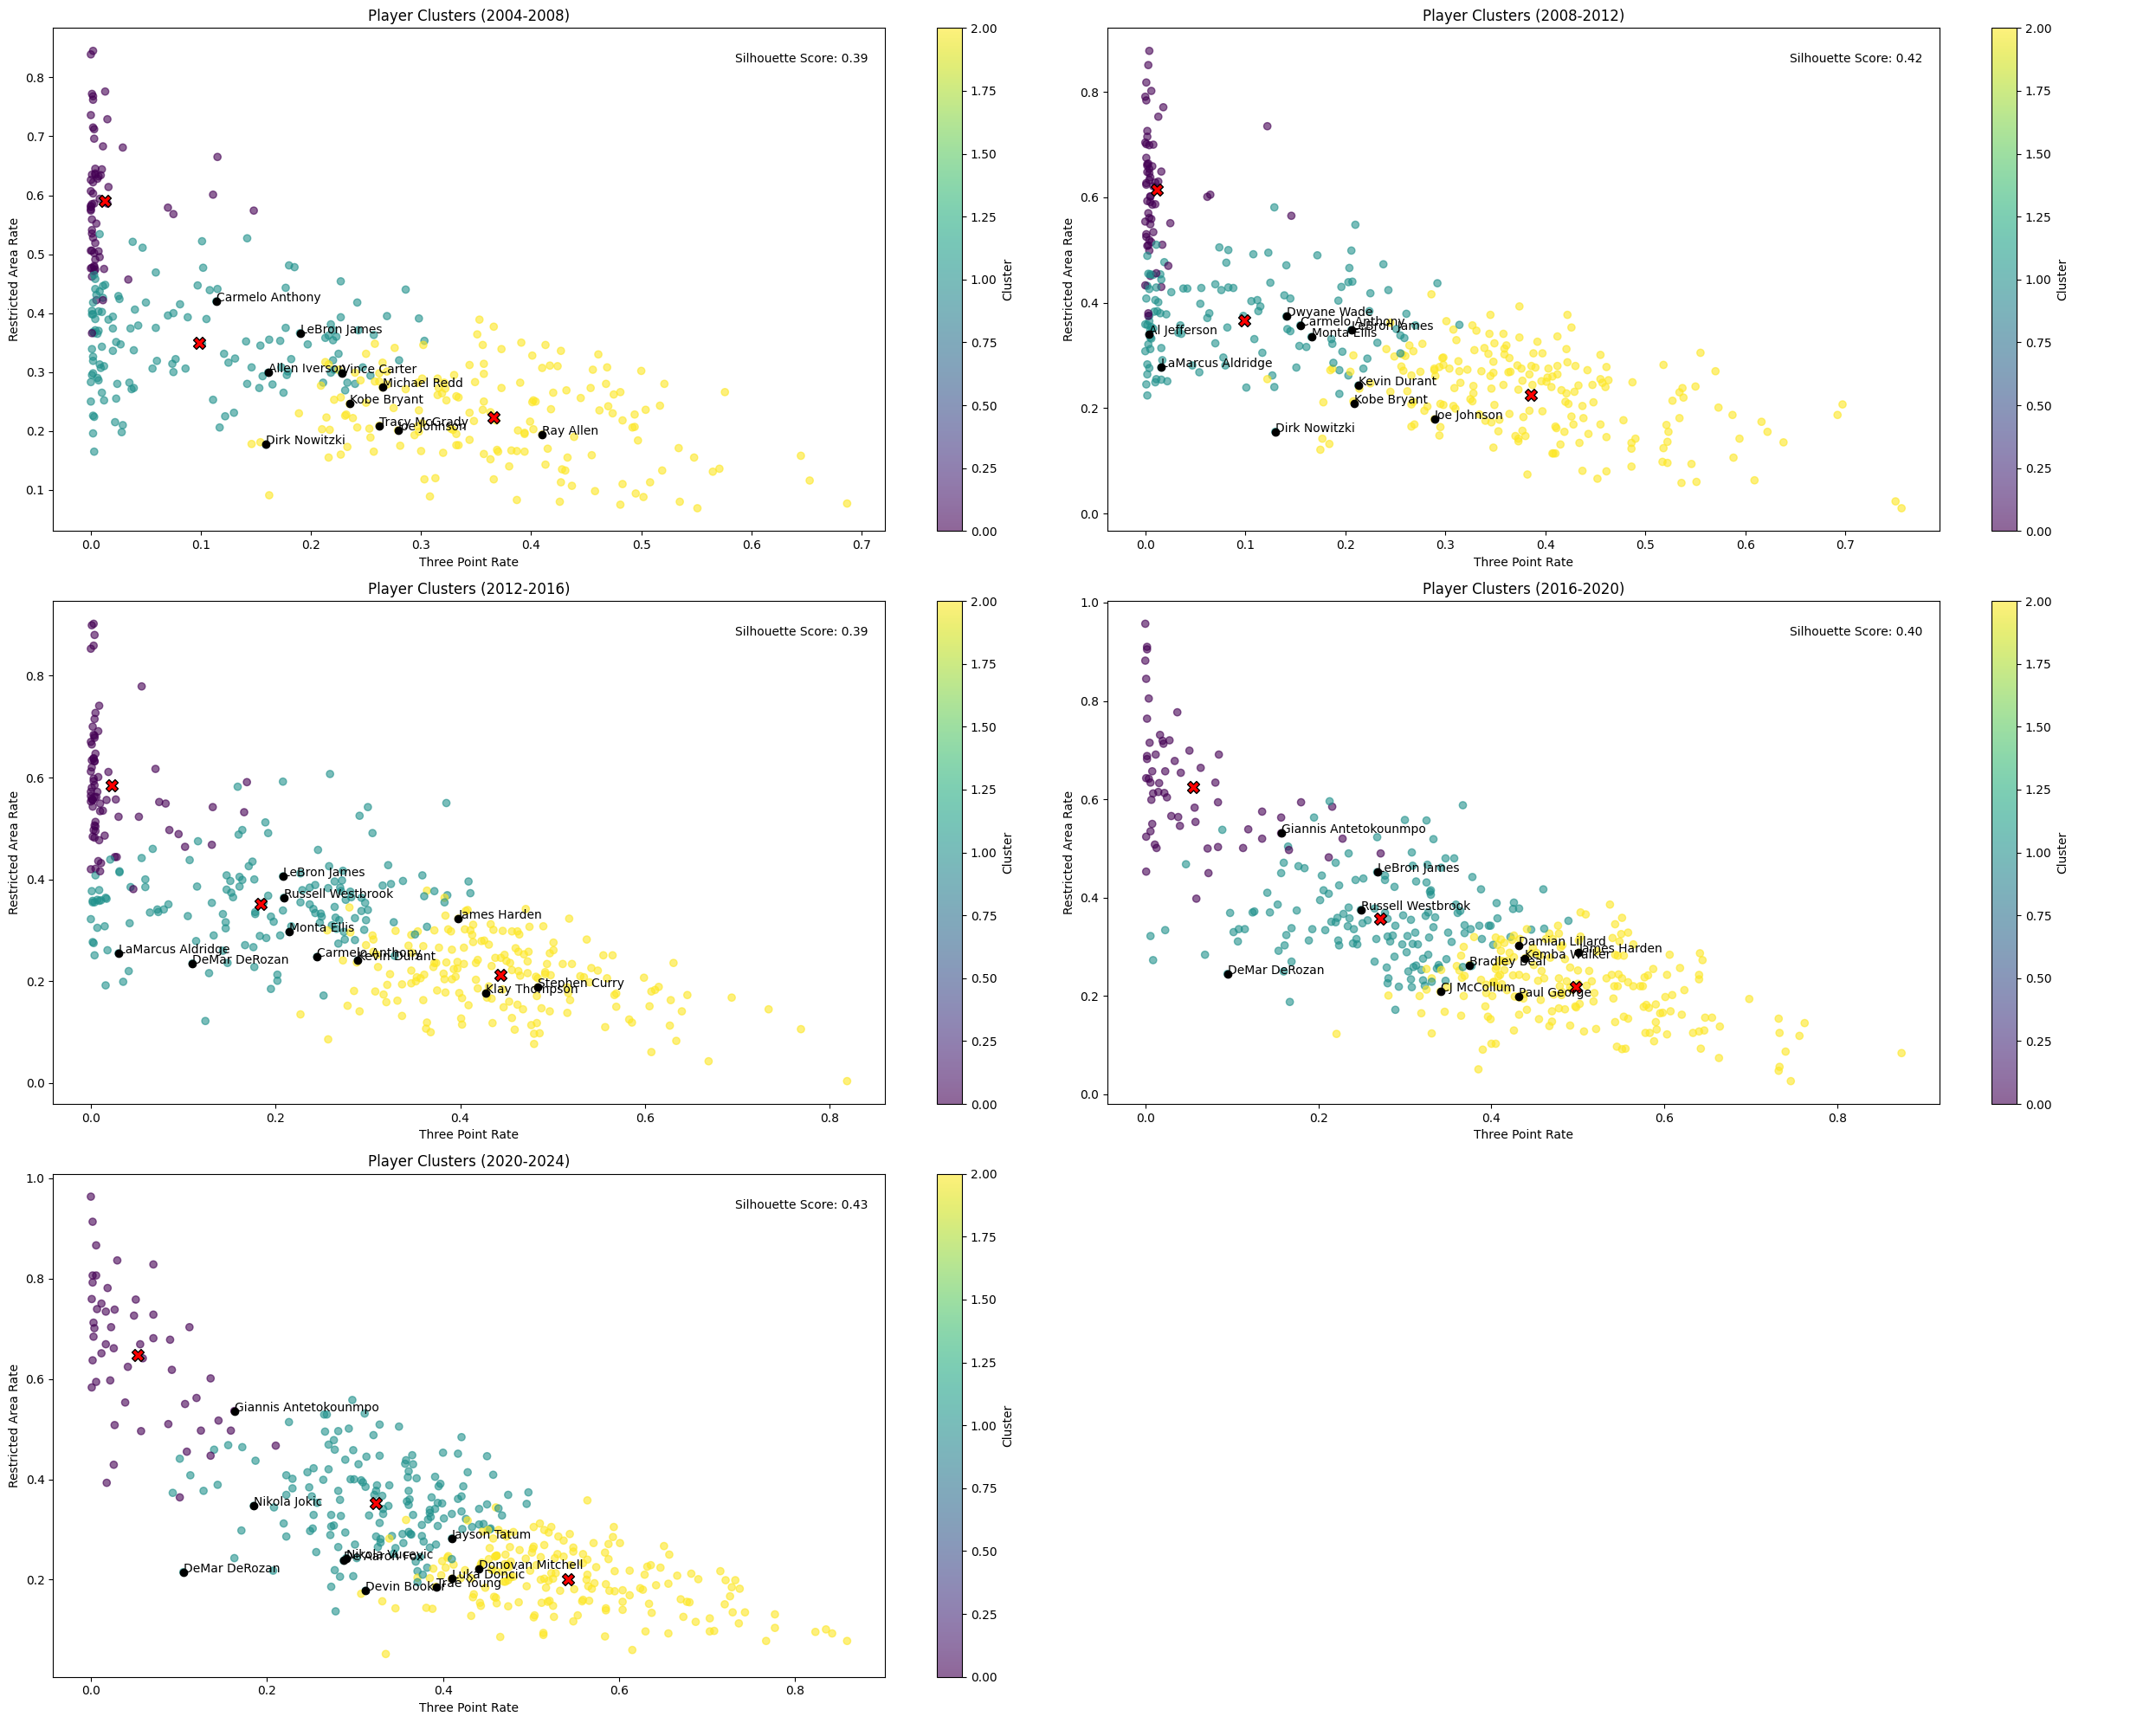

In [14]:
periods = {
    '2004-2008': df_2004_2008[df_2004_2008['TOTAL_SHOTS'] >= 500],
    '2008-2012': df_2008_2012[df_2008_2012['TOTAL_SHOTS'] >= 500],
    '2012-2016': df_2012_2016[df_2012_2016['TOTAL_SHOTS'] >= 500],
    '2016-2020': df_2016_2020[df_2016_2020['TOTAL_SHOTS'] >= 500],
    '2020-2024': df_2020_2024[df_2020_2024['TOTAL_SHOTS'] >= 500]
}
center_data = []
num_periods = len(periods)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(25, 20))
axes = axes.flatten()
axes[-1].axis('off')

for idx, (period_name, profiles) in enumerate(periods.items()):
    profiles_clustered, sil_score, centers = cluster_profiles(profiles)
    ax = axes[idx]
    scatter = ax.scatter(profiles_clustered['THREE_POINT_RATE'], 
                         profiles_clustered['RESTRICTED_AREA_RATE'],
                         c=profiles_clustered['Cluster'], 
                         cmap="viridis",
                         alpha=0.6,
                         label = "Players")
    ax.scatter(centers[:, 0], centers[:, 1],
                                c="red",
                                marker='X',
                                s=100,
                                label='Cluster Centers',
                                edgecolor='black')
    for cluster_num in range(len(centers)):
        center_data.append({
            'period': period_name,
            'cluster': cluster_num,
            'three_point_rate': centers[cluster_num, 0],
            'restricted_area_rate': centers[cluster_num, 1]
        })
        
    top_players = profiles_clustered.sort_values('TOTAL_SHOTS', ascending=False).head(10)

    for idx, row in top_players.iterrows():
        point_x, point_y = row['THREE_POINT_RATE'], row['RESTRICTED_AREA_RATE']
        ax.scatter(point_x, point_y, color='black')
        ax.annotate(idx, (point_x, point_y), color='black')
        
    ax.annotate(f'Silhouette Score: {sil_score:.2f}',
                xy=(0.98, 0.95), 
                xycoords='axes fraction', 
                ha='right',
                va = 'top')
    
    ax.set_xlabel('Three Point Rate')
    ax.set_ylabel('Restricted Area Rate')
    ax.set_title(f'Player Clusters ({period_name})')
    cbar = fig.colorbar(scatter, ax=ax, label='Cluster', orientation='vertical')
plt.tight_layout()

centers_df = pd.DataFrame(center_data).sort_values(['period', 'cluster']).reset_index(drop=True)

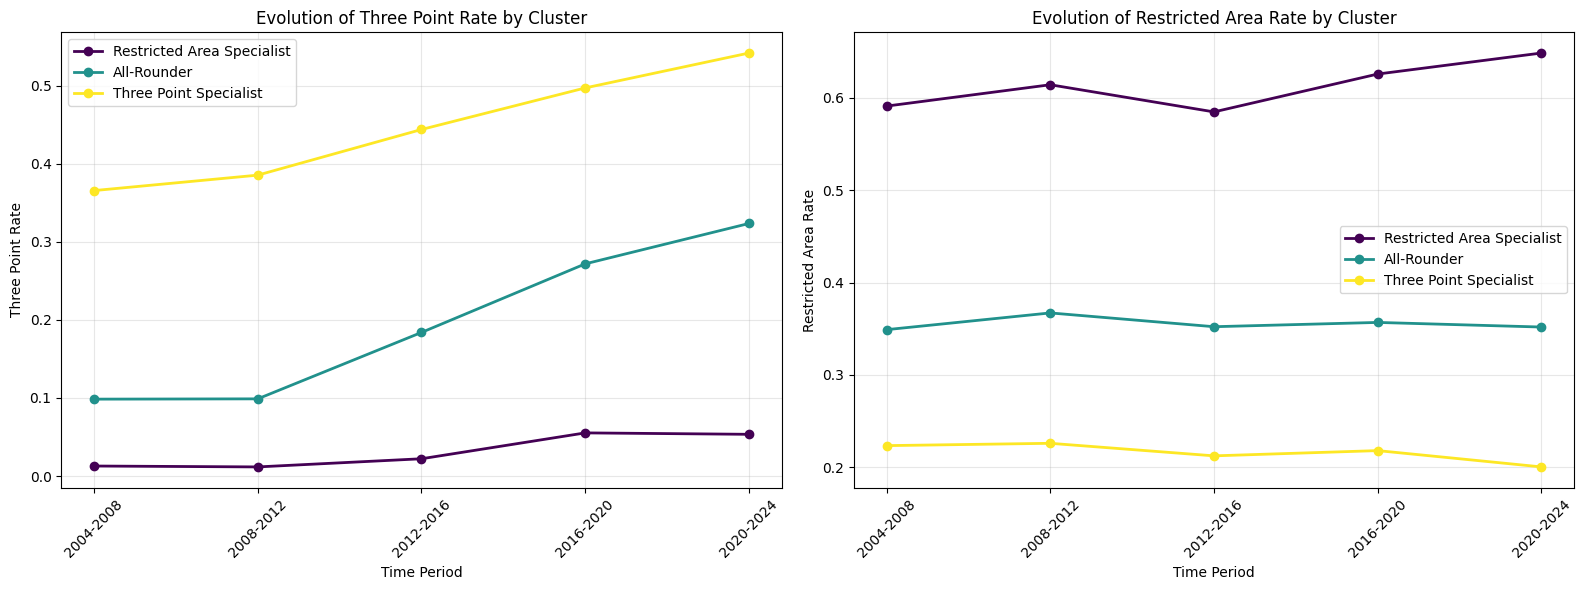

In [15]:
colors = plt.cm.viridis(np.linspace(0, 1, 3))
cluster_labels = ["Restricted Area Specialist", "All-Rounder", "Three Point Specialist"]
focus = ['three_point_rate', 'restricted_area_rate']

plt.figure(figsize=(16, 6))
for i in range(2):
    plt.subplot(1, 2, i+1)
    title = focus[i].replace('_', ' ').title()
    for cluster in range(3):
        mask = centers_df['cluster'] == cluster
        plt.plot(centers_df[mask]['period'], 
                centers_df[mask][focus[i]], 
                marker='o',
                linewidth=2,
                label=cluster_labels[cluster],
                color = colors[cluster])
    plt.title(f'Evolution of {title} by Cluster')
    plt.xlabel('Time Period')
    plt.ylabel(title)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend()
plt.tight_layout()

While the prompt asked for three time periods of 2012-2016, 2016-2020, and 2020-2024, I decided to include 2004-2008 and 2008-2012.  There are some irregularities I'm aware of with rule shifts and styles of play that made the prior two time periods a bit different in terms of statistics, but as a whole I didn't find an extremely valid reason to not include them.

I chose to select a k-value of 3 because of the way the data seemed to naturally be grouped into restricted area specialists who have high restricted area rates with low three point rates (cluster 0), three point specialists who have high three point percentage but poorer restricted area rates (cluster 2), and all-rounders, who have a mix of both.  That k-value for n_clusters is not actually the value that maximizes the sihouette score (which would be n_clusters = 2), but it is the lowest that I am willing to use given how any lower makes the clusters too simplistic with a clear 'restricted area specialist' cluster and another extremely large cluster that isn't very descript.

When analyzing players via these clusters, it paints a picture of a shifting style of play.  Player archetypes amidst this change remain similar, but with notable differences.  There is an increase throughout all groups with three point rate, with the three specialists and the all-rounders increasing largely over time.  For restricted area play, the rates are roughly fairly flat throughout the board.  Where one would expect the three point specialists to be good at their specialization, the all-rounders reaching three point rates in 2024 roughly where the specialists were at in 2004 indicate a shift towards that style of flat writ large, despite the continued existence of the restricted area specialist archetype.  Notably, though, that restricted specialist grouping is largely dying as there are far less concentrated points in the extreme area with very low three point but very high restricted area rate in more recent times compared to the 2000s.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## 3. Prediction Task (No Deep Learning)



Build a model to predict shot success (SHOT_MADE) given available features, and improve their accuracy by creating features and hyperparameter tuning. You may drop some features if you feel that they would improve your accuracy. 

You are given the train and test splits (run the first cell and look into the `datasets` folder). Note that the test file does NOT contain labels! The test.csv is what you will ultimately make predictions on. You are free to split the train.csv file into its own train-test splits as you like. 

Feature engineering can include:
- Spatial features (shot angle derived from LOC_X, LOC_Y).
- Shot difficulty: A derived feature combining SHOT_DISTANCE, LOC_X, LOC_Y, and SHOT_TYPE.
- Player fatigue: An engineered metric estimating player fatigue based on game date (GAME_DATE) and time in the game.

Prediction methods can include logistic regression, decision trees, random forests, gradient boosting, etc (including things we haven't covered!). However, you are NOT allowed to use deep learning for this task. 

Objective: Beat the benchmark accuracy score on the test set (`test.csv`). Create a submission file following the format of 'submission_example.csv' and upload to Kaggle. Kaggle will run accuracy calculation and show you how you rank amongst the submissions of others.

#### Creating the submission file. 



You should follow the format of `submission.csv` (also provided):

```{python}
submission_df = pd.read_csv("./submission.csv", index_col=0)
submission_df['SHOT_MADE'] = # your predictions
submission_df.to_csv("./submission.csv", index=True, index_label="ID")
```

Then upload the file to the Kaggle competition to get your leaderboard score. 

In [3]:
df = pd.read_csv("./datasets/train.csv")
test_df = pd.read_csv("./datasets/test.csv")

In [50]:
def preprocessing(df, features):
    df[['MINS_LEFT', 'SECS_LEFT', 'QUARTER']] = df[['MINS_LEFT', 'SECS_LEFT', 'QUARTER']].apply(round)
    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
    df.fillna({'GAME_DATE': df.groupby('SEASON_2')['GAME_DATE'].transform('mean'), 'LOC_X': df['LOC_X'].mean(), 'LOC_Y': df['LOC_Y'].mean(), 'POSITION': 'No Position'}, inplace=True)

    df['TOTAL_GAME_TIME'] = (df['QUARTER'] - 1) * 720 + (720 - df['MINS_LEFT'] * 60 + df['SECS_LEFT'])
    df['DAYS_FROM_FIRST_DAY'] = (df['GAME_DATE'] - df.groupby(['PLAYER_NAME', 'SEASON_2'])['GAME_DATE'].transform('min')).dt.days

    df['DISTANCE_FROM_CENTER'] = np.sqrt(df['LOC_X']**2 + df['LOC_Y']**2)
    df['SHOT_ANGLE'] = np.degrees(np.arctan2(df['LOC_Y'], df['LOC_X']))
    df['FATIGUE_SCORE'] = df['DAYS_FROM_FIRST_DAY'] * df['TOTAL_GAME_TIME']

    scaler = StandardScaler()
    encoder = LabelEncoder()
    continuous_columns = list(set(df.select_dtypes(include=['float64', 'int64']).columns) & set(features))
    categorical_columns = list(set(df.select_dtypes(include=['object']).columns) & set(features))
    df[continuous_columns] = scaler.fit_transform(df[continuous_columns])
    df[categorical_columns] = df[categorical_columns].apply(lambda x: encoder.fit_transform(x))
    return df

In [51]:
features = ['PLAYER_ID', 'GAME_ID', 'HOME_TEAM', 'ACTION_TYPE', 'BASIC_ZONE', 'ZONE_RANGE', 'SHOT_DISTANCE', 'DISTANCE_FROM_CENTER', 'SHOT_ANGLE']
target = 'SHOT_MADE'

In [52]:
model_df = preprocessing(df, features)
X, y = model_df[features], model_df[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
model = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=2,
        min_samples_leaf=14,
        n_jobs=-1,
        random_state=42)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=14, n_estimators=200,
                       n_jobs=-1, random_state=42)

In [54]:
y_pred = model.predict(X_val)
score, report = accuracy_score(y_val, y_pred), classification_report(y_val, y_pred)
print("Accuracy:", score)
print(report)

Accuracy: 0.6473791805637207
              precision    recall  f1-score   support

       False       0.63      0.84      0.72    366884
        True       0.69      0.41      0.52    310118

    accuracy                           0.65    677002
   macro avg       0.66      0.63      0.62    677002
weighted avg       0.66      0.65      0.63    677002



In [55]:
feature_importance = model.feature_importances_
unimportant_features = X.columns[feature_importance < 0.03]
unimportant_features

Index([], dtype='object')

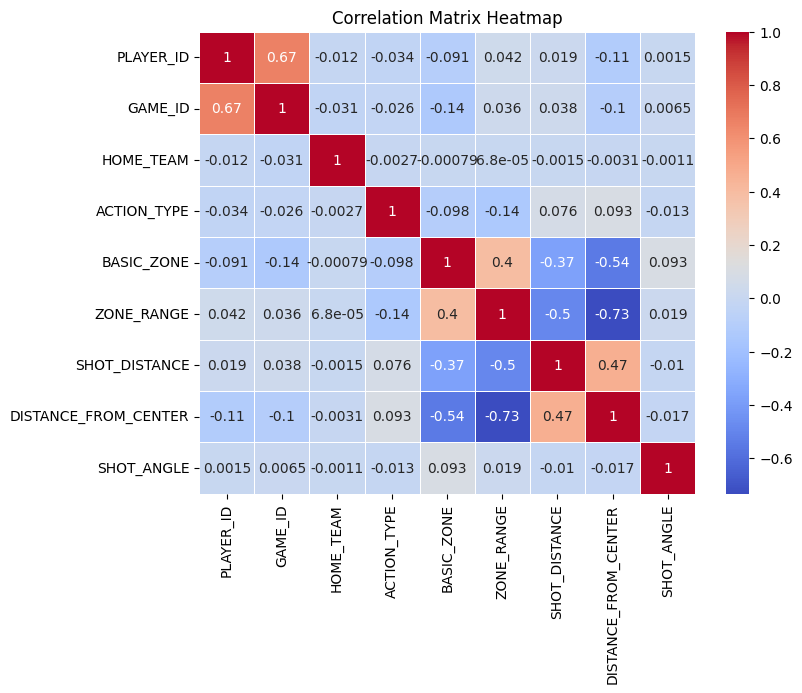

In [56]:
correlation_matrix = model_df[features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [57]:
test_model_df = preprocessing(test_df, features)[features]
predictions = model.predict(test_model_df)
submission = pd.DataFrame({'ID': test_df['Unnamed: 0'], target : predictions})

In [58]:
submission.to_csv('submission.csv', index=False)

I utilized a RandomForestClassifier because the way that it uses decision trees seems to match how real decisions are made in this context.  Having some knowledge of statistical analysis of basketball, there are certain larger focuses on certain stats such as points, assists, rebounds, before analysis goes further into field goal percentages and the like.  Effectively, the way that people in basketball make statistical analytical decisions reminds me of decision trees.  As for the parameters, I decided them after the features and it mostly came as a result of testing different configurations for the highest accuracy on the test set.
In my prediction, I specifically included certain features and excluded others.

A feature I used was "DISTANCE_FROM_CENTER" which combined "LOC_X" and "LOC_Y" into a more useful stat by getting the square root of the sum of their squares.  I found this was more reliable as a better measure of actual proximity to the rim, which is, after all, the main goal of basketball.  When compared to "LOC_X" and "LOC_Y", which were somewhat limited in their score, "DISTANCE_FROM_CENTER" felt like it more wholistically captured a multidimensional sense of distance.

"SHOT_ANGLE" was a feature I created that also derived from "LOC_X" and "LOC_Y".  It calculated an arctan2 of "LOC_X" and "LOC_Y" in order to measure a shot angle, which, similar to "DISTANCE_FROM_CENTER", felt like it captured distance in a different sense.  While its components heavily overlapped with "DISTANCE_FROM_CENTER", it added quite a bit of accuracy to my model which to me made its continued inclusion necessary despite being rather low in terms of feature_importances.

As for the other features, the rest of the features that I did not engineer were from the dataset and were kept in based on if their feature_importance was over the threshold of 0.01, or if it had high correlation with other features.  However, I did not remove some other features despite high correlation from other features because removing either lowered accuracy too much for my liking.

In my preprocessing file, there is a "FATIGUE_SCORE" feature included, calculated from factoring in both the total game time, which in my view measured short term fatigue as in how tired a player was due to playing that day, and the days it had been between that row's game and the first game that season that the player had played, a statistic which I felt captured a more long term fatigue effect counting in nagging injuries and overall wear and tear.  However, it had rather low feature importance so I ultimately did not use it in the model.  Still, I have kept it in the preprocessing file because it represents one of this question's suggested feature engineering types.

To show this model's accuracy here is the classification report again:

In [59]:
print(score)
print(report)

0.6473791805637207
              precision    recall  f1-score   support

       False       0.63      0.84      0.72    366884
        True       0.69      0.41      0.52    310118

    accuracy                           0.65    677002
   macro avg       0.66      0.63      0.62    677002
weighted avg       0.66      0.65      0.63    677002



<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Question 4: Optional (Bonus) Advanced visualizations and analysis


This is an optional problem worth 5 bonus points. It is an open-ended question. We are asking you to create a single novel and possibly interactive visualization
that shows an interesting insight into the data. Some examples could be:

- a shot heatmap for players or teams,
- game-winning (or tying) clutch shot analysis
- career makes from a particular player shown on a court graphic
- progression of shots from a particular player (or players at a particular position) over time

However you are free to design this yourself. Earning the bonus should be beyond the scope of a simple EDA and should involve a few steps of analysis prior to the visualization. 

Your plots should be on a professional level visually. This means they should have proper labels, titles, legends, and the font sizes should make the visualization clear.

Since this part is more open-ended than the others, it is optional. 

In [33]:
# All attribution to https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    if ax is None:
        ax = plt.gca()
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color, fill=False)
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color, fill=False)
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180, linewidth=lw, color=color, fill=False)
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0, linewidth=lw, color=color, linestyle='dashed')
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw, color=color)
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw, color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw, color=color)
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0, linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0, linewidth=lw, color=color)
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw, bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc, center_inner_arc]

    if outer_lines:
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw, color=color, fill=False)
        court_elements.append(outer_lines)
    for element in court_elements:
        ax.add_patch(element)
    return ax

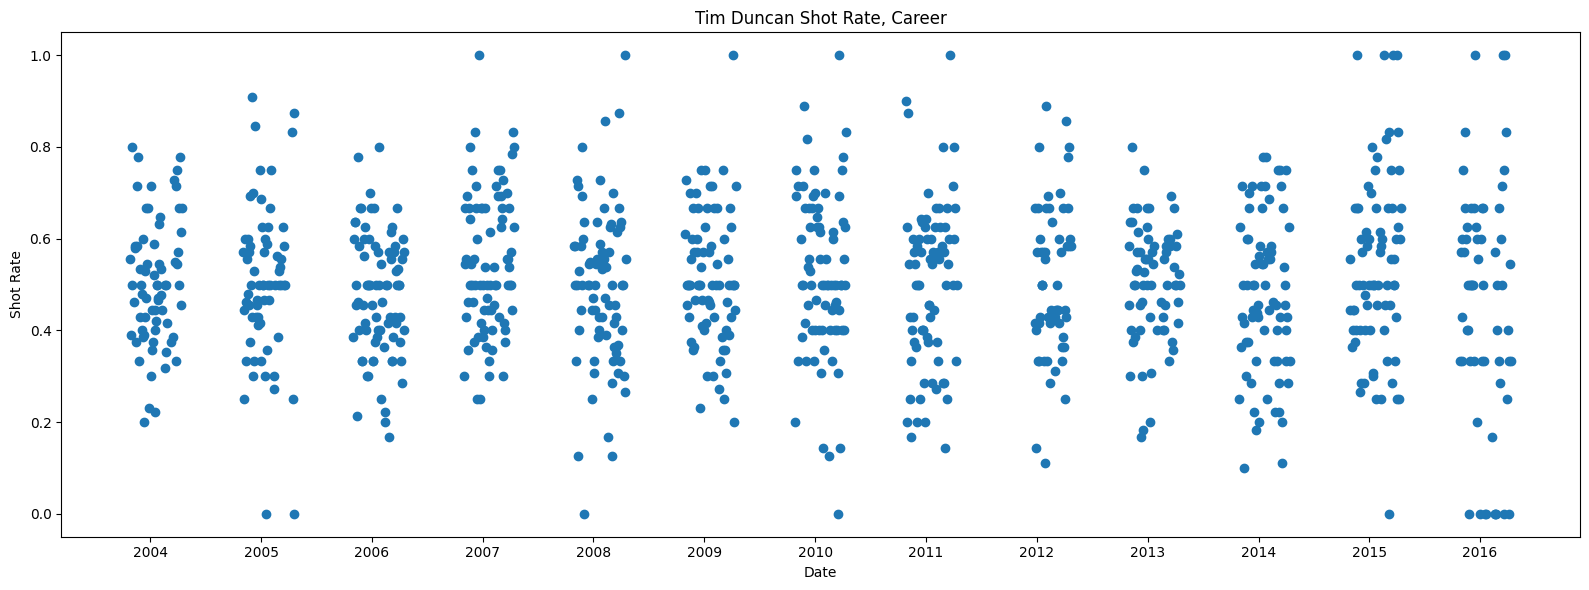

In [34]:
duncan_df = df[df['PLAYER_NAME'] == 'Tim Duncan']
duncan_df.loc[:, 'GAME_DATE'] = pd.to_datetime(duncan_df['GAME_DATE'])
plot_df = duncan_df.groupby('GAME_DATE').agg(SHOT_COUNT=('SHOT_MADE', 'count'),
                                                                           SHOTS_MADE=('SHOT_MADE', 'sum'),
                                                                           SHOTS_SUCCESS_RATE=('SHOT_MADE', lambda x: x.sum()/x.count())).reset_index()

plt.figure(figsize=(16, 6))
plt.scatter(plot_df['GAME_DATE'], plot_df['SHOTS_SUCCESS_RATE'])
plt.gca().xaxis.set_major_locator(YearLocator(1))
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.xlabel("Date")
plt.ylabel("Shot Rate")
plt.title("Tim Duncan Shot Rate, Career")
plt.tight_layout()

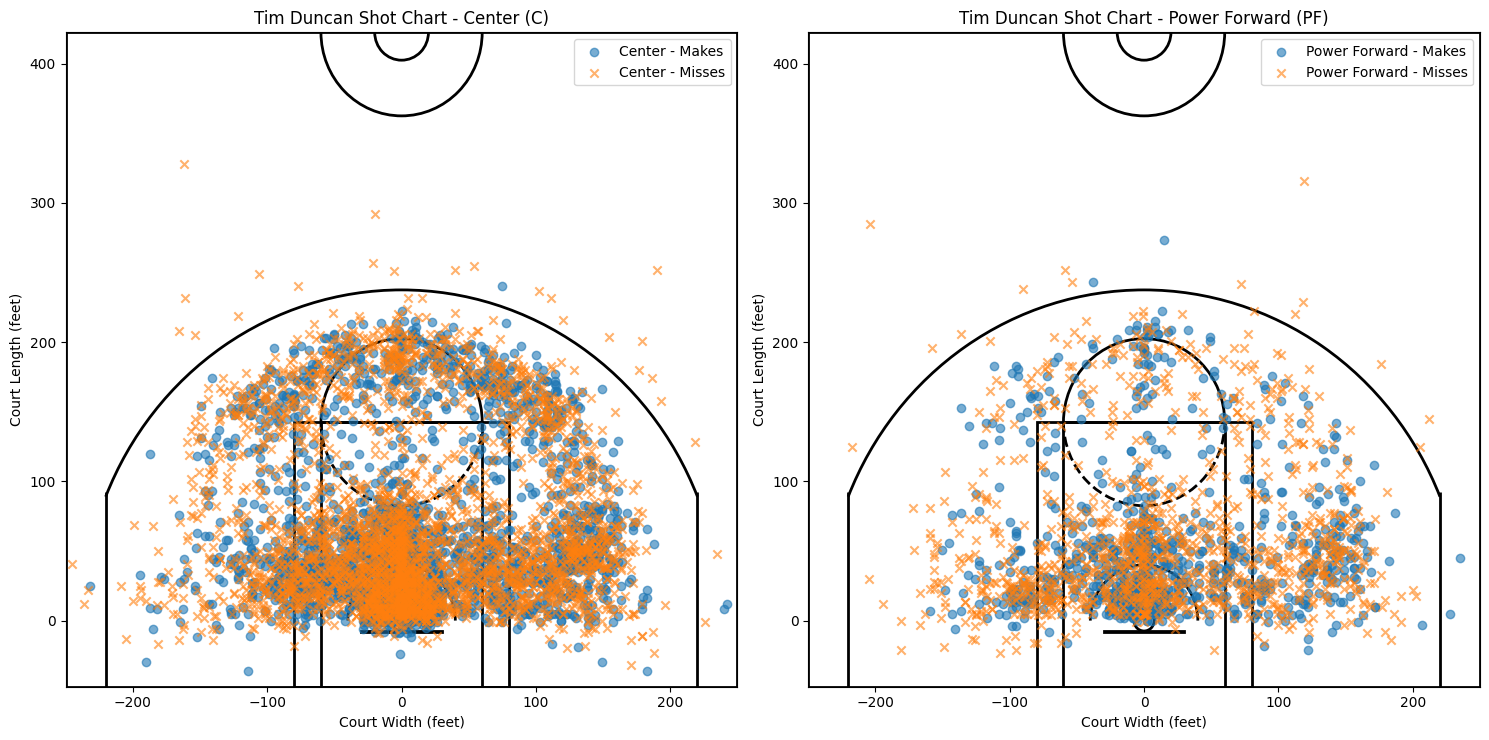

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 7.5))

ax[0].set_title("Tim Duncan Shot Chart - Center (C)")
draw_court(ax[0], color='black', lw=2, outer_lines=True)

duncan_df = df[df['PLAYER_NAME'] == 'Tim Duncan']
duncan_df.loc[:, 'LOC_X'] = duncan_df['LOC_X'] * 10
duncan_df.loc[:, 'LOC_Y'] = duncan_df['LOC_Y'] * 10 - 47.5

position_df = duncan_df[duncan_df['POSITION'] == 'C']
made_shots = position_df[position_df['SHOT_MADE'] == True]
missed_shots = position_df[position_df['SHOT_MADE'] == False]
ax[0].scatter(made_shots['LOC_X'], made_shots['LOC_Y'], label="Center - Makes", alpha=0.6, marker='o')
ax[0].scatter(missed_shots['LOC_X'], missed_shots['LOC_Y'], label="Center - Misses", alpha=0.6, marker='x')

ax[1].set_title("Tim Duncan Shot Chart - Power Forward (PF)")
draw_court(ax[1], color='black', lw=2, outer_lines=True)

position_df = duncan_df[duncan_df['POSITION'] == 'PF']
made_shots = position_df[position_df['SHOT_MADE'] == True]
missed_shots = position_df[position_df['SHOT_MADE'] == False]
ax[1].scatter(made_shots['LOC_X'], made_shots['LOC_Y'], label="Power Forward - Makes", alpha=0.6, marker='o')
ax[1].scatter(missed_shots['LOC_X'], missed_shots['LOC_Y'], label="Power Forward - Misses", alpha=0.6, marker='x')

for i in ax:
    i.set_xlim(-250, 250)
    i.set_ylim(-47.5, 422.5)
    i.set_xlabel("Court Width (feet)")
    i.set_ylabel("Court Length (feet)")
    i.legend(loc="upper right")

plt.tight_layout()
plt.show()


## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [29]:
import os
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']

In [30]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:


